# **Part 2 - Transfer learning**

# **1. Transfer Learning for Images**

## **Setup**

In [13]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

In [14]:

# Load the CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Normalize the images
subset_fraction = 0.2
subset_size = int(len(train_images) * subset_fraction)
indices = np.random.choice(range(len(train_images)), subset_size, replace=False)
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Convert labels to one-hot encoded format
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)


## **Fine-tuning**

In [15]:


# Load pre-trained VGG16 model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the layers

# Add custom layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)  # Assume 10 classes
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


## **Feature Extraction and training**

Epoch 1/5
391/391 [==============================] - 556s 1s/step - loss: 1.5133 - accuracy: 0.4675
Epoch 2/5
391/391 [==============================] - 561s 1s/step - loss: 1.3748 - accuracy: 0.5132
Epoch 3/5
391/391 [==============================] - 540s 1s/step - loss: 1.3312 - accuracy: 0.5306
Epoch 4/5
391/391 [==============================] - 536s 1s/step - loss: 1.2990 - accuracy: 0.5407
Epoch 5/5
391/391 [==============================] - 537s 1s/step - loss: 1.2690 - accuracy: 0.5492


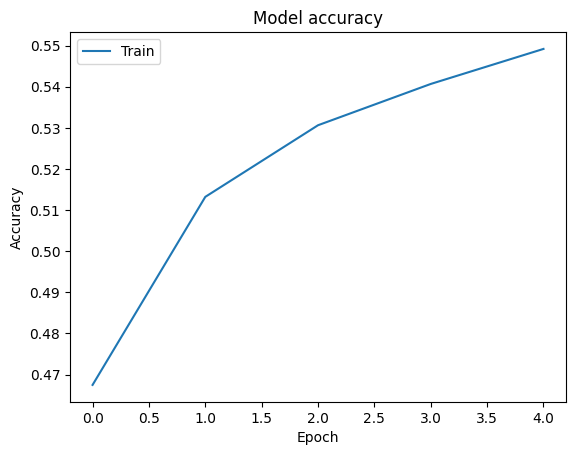

In [17]:
# Data preparation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Using .flow() to prepare data
train_generator = train_datagen.flow(
    train_images,
    train_labels,
    batch_size=128
)

# Training the model
history = model.fit(train_generator, epochs=5)

# Visualization
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

# **2. Transfer Learning for Videos**

## **Setup**

In [3]:
!pip install tensorflow-datasets


## **Creating base video model for feature extraction**

In [23]:
from tensorflow.keras.layers import Input, ConvLSTM2D, BatchNormalization, Dense, Flatten, TimeDistributed, GlobalAveragePooling1D
from tensorflow.keras.models import Model

def create_video_model():
    input_layer = Input(shape=(None, 64, 64, 1))
    x = ConvLSTM2D(filters=64, kernel_size=(3, 3), return_sequences=True)(input_layer)
    x = BatchNormalization()(x)
    x = ConvLSTM2D(filters=32, kernel_size=(3, 3), return_sequences=True)(x)
    x = BatchNormalization()(x)
    x = ConvLSTM2D(filters=16, kernel_size=(3, 3), return_sequences=False)(x)
    x = Flatten()(x)
    output_layer = Dense(10, activation='softmax')(x)  # Assuming 10 classes
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

# Instantiate and compile the base model
base_model = create_video_model()
base_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Freeze the layers of the base model for feature extraction
for layer in base_model.layers:
    layer.trainable = False


## **Custom Classifier**

In [24]:
# Adding new layers on top of the frozen base model
new_output = Dense(10, activation='softmax')(base_model.output)  # New classifier layer for the same or different task
model_for_extraction = Model(inputs=base_model.input, outputs=new_output)
model_for_extraction.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


## **Training the Feature Extraction Model**

In [25]:
# Prepare the dataset
train_dataset = tf.data.Dataset.from_tensor_slices((videos, labels))
train_dataset = train_dataset.batch(8)

# Train the model with frozen base layers
extraction_history = model_for_extraction.fit(train_dataset, epochs=5)


Epoch 1/5
125/125 [==============================] - 50s 355ms/step - loss: 2.1047 - accuracy: 0.0000e+00
Epoch 2/5
125/125 [==============================] - 42s 337ms/step - loss: 1.6927 - accuracy: 0.0000e+00
Epoch 3/5
125/125 [==============================] - 42s 333ms/step - loss: 1.3328 - accuracy: 0.0000e+00
Epoch 4/5
125/125 [==============================] - 42s 335ms/step - loss: 1.0339 - accuracy: 0.0000e+00
Epoch 5/5
125/125 [==============================] - 42s 335ms/step - loss: 0.7972 - accuracy: 0.0000e+00


In [28]:
# Adjust the model architecture slightly
from tensorflow.keras.optimizers import Adam

model = Sequential([
    ConvLSTM2D(filters=64, kernel_size=(3, 3), return_sequences=True, input_shape=(None, 64, 64, 1)),
    BatchNormalization(),
    ConvLSTM2D(filters=32, kernel_size=(3, 3), return_sequences=True),
    BatchNormalization(),
    ConvLSTM2D(filters=16, kernel_size=(3, 3), return_sequences=False),
    Flatten(),
    Dense(50, activation='relu'),  # Additional dense layer
    Dense(10, activation='softmax')
])

# Use a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Re-run training
history = model.fit(train_dataset, epochs=5)


Epoch 1/5
125/125 [==============================] - 122s 914ms/step - loss: 0.0172 - accuracy: 0.0000e+00
Epoch 2/5
125/125 [==============================] - 114s 913ms/step - loss: 7.0847e-07 - accuracy: 0.0000e+00
Epoch 3/5
125/125 [==============================] - 115s 916ms/step - loss: 6.1197e-07 - accuracy: 0.0000e+00
Epoch 4/5
125/125 [==============================] - 114s 915ms/step - loss: 5.1570e-07 - accuracy: 0.0000e+00
Epoch 5/5
125/125 [==============================] - 114s 914ms/step - loss: 4.3300e-07 - accuracy: 0.0000e+00


## **Fine tuning**

In [29]:
# Unfreeze the last few layers of the base model
for layer in base_model.layers[-3:]:
    layer.trainable = True

# Re-compile the model for fine-tuning
model_for_extraction.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Continue training
fine_tuning_history = model_for_extraction.fit(train_dataset, epochs=5, initial_epoch=extraction_history.epoch[-1])


Epoch 5/5
125/125 [==============================] - 108s 421ms/step - loss: 0.2926 - accuracy: 0.0000e+00


## **Visualizations**

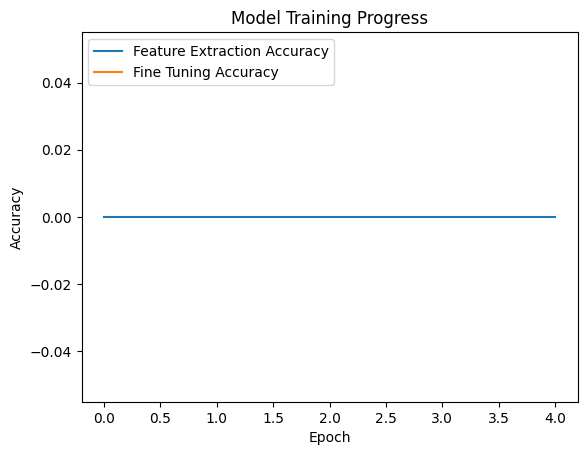

In [30]:
import matplotlib.pyplot as plt

plt.plot(extraction_history.history['accuracy'], label='Feature Extraction Accuracy')
plt.plot(fine_tuning_history.history['accuracy'], label='Fine Tuning Accuracy')
plt.title('Model Training Progress')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


# **3. Transfer Learning for Audios**

In [14]:
import numpy as np
import tensorflow as tf

def generate_sine_waves(batch_size=1000, duration=1.0, sampling_rate=44100):
    # Frequencies for the sine waves
    freqs = np.random.randint(100, 2000, size=batch_size)  # Random frequencies between 100 Hz and 2 kHz
    t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)
    data = np.sin(2 * np.pi * freqs[:, np.newaxis] * t)
    labels = (freqs - 100) / 1900  # Normalize frequencies to a 0-1 range

    return data.astype(np.float32), labels.astype(np.float32)

# Example usage
audio_data, labels = generate_sine_waves()


## **Pre-trained Model Simulation**

In [18]:
from tensorflow.keras.layers import Input, Conv1D, GlobalAveragePooling1D, Dense, Flatten
from tensorflow.keras.models import Model

def create_pretrained_audio_model(input_shape):
    inp = Input(shape=input_shape)
    x = Conv1D(64, kernel_size=3, activation='relu')(inp)
    x = Conv1D(64, kernel_size=3, activation='relu')(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(32, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)  # Simulating a pre-trained task
    model = Model(inputs=inp, outputs=output)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Simulate pre-training by training on synthetic data
pretrained_model = create_pretrained_audio_model((44100, 1))
# Assume we train it here (skipping actual training for brevity)


## **Audio Processing Model**

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, GlobalAveragePooling1D

def create_audio_model():
    model = Sequential([
        Conv1D(16, 3, activation='relu', input_shape=(44100, 1)),  # Assuming 1-second audio at 44.1 kHz
        Conv1D(32, 3, activation='relu'),
        GlobalAveragePooling1D(),
        Dense(1, activation='sigmoid')  # Output a single value as normalized frequency
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

model = create_audio_model()


## **Feature Extraction**

In [19]:
for layer in pretrained_model.layers:
    layer.trainable = False  # Freeze all layers

# Add new classifier on top of the pre-trained base
feature_extractor_input = pretrained_model.input
new_output = Dense(1, activation='sigmoid')(pretrained_model.output)  # New task: frequency prediction
feature_extractor_model = Model(inputs=feature_extractor_input, outputs=new_output)

feature_extractor_model.compile(optimizer='adam', loss='mse', metrics=['mae'])


## **Training the Audio Model**

In [16]:
# Reshape data for the model
audio_data = audio_data[..., np.newaxis]  # Add channel dimension

# Train the model
history = model.fit(audio_data, labels, epochs=10, validation_split=0.1)


Epoch 1/10
29/29 [==============================] - 5s 52ms/step - loss: 0.0867 - mae: 0.2573 - val_loss: 0.0747 - val_mae: 0.2305
Epoch 2/10
29/29 [==============================] - 1s 40ms/step - loss: 0.0835 - mae: 0.2522 - val_loss: 0.0688 - val_mae: 0.2231
Epoch 3/10
29/29 [==============================] - 1s 40ms/step - loss: 0.0800 - mae: 0.2471 - val_loss: 0.0660 - val_mae: 0.2179
Epoch 4/10
29/29 [==============================] - 1s 41ms/step - loss: 0.0744 - mae: 0.2382 - val_loss: 0.0605 - val_mae: 0.2083
Epoch 5/10
29/29 [==============================] - 1s 41ms/step - loss: 0.0667 - mae: 0.2256 - val_loss: 0.0521 - val_mae: 0.1935
Epoch 6/10
29/29 [==============================] - 1s 41ms/step - loss: 0.0553 - mae: 0.2055 - val_loss: 0.0408 - val_mae: 0.1710
Epoch 7/10
29/29 [==============================] - 1s 41ms/step - loss: 0.0411 - mae: 0.1763 - val_loss: 0.0289 - val_mae: 0.1428
Epoch 8/10
29/29 [==============================] - 2s 54ms/step - loss: 0.0273 - m

## **Visualizing the results**

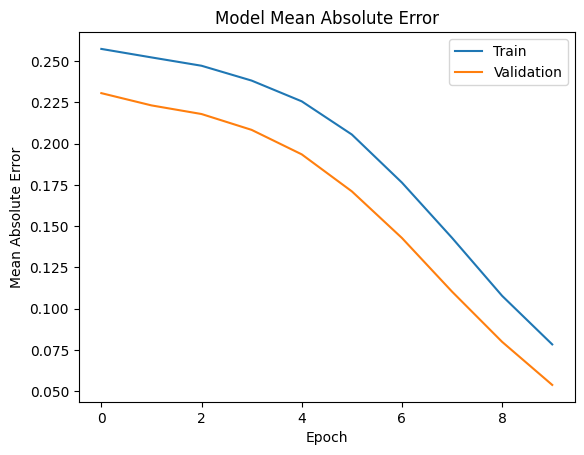

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model Mean Absolute Error')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


## **Training the Feature Extractor Model**

In [20]:
# Train the feature extractor model
feature_history = feature_extractor_model.fit(audio_data, labels, epochs=5, validation_split=0.1)


Epoch 1/5
29/29 [==============================] - 3s 56ms/step - loss: 0.0874 - mae: 0.2585 - val_loss: 0.0743 - val_mae: 0.2315
Epoch 2/5
29/29 [==============================] - 1s 48ms/step - loss: 0.0874 - mae: 0.2585 - val_loss: 0.0744 - val_mae: 0.2315
Epoch 3/5
29/29 [==============================] - 1s 49ms/step - loss: 0.0874 - mae: 0.2585 - val_loss: 0.0747 - val_mae: 0.2318
Epoch 4/5
29/29 [==============================] - 1s 47ms/step - loss: 0.0874 - mae: 0.2584 - val_loss: 0.0748 - val_mae: 0.2319
Epoch 5/5
29/29 [==============================] - 1s 47ms/step - loss: 0.0874 - mae: 0.2584 - val_loss: 0.0749 - val_mae: 0.2320


## **Fine-Tuning**

In [21]:
# Unfreeze the last convolutional layer
pretrained_model.layers[-3].trainable = True

# Compile the model again (necessary to apply the unfreezing)
feature_extractor_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Continue training
fine_tune_history = feature_extractor_model.fit(audio_data, labels, epochs=5, validation_split=0.1, initial_epoch=feature_history.epoch[-1])


Epoch 5/5
29/29 [==============================] - 2s 54ms/step - loss: 0.0874 - mae: 0.2584 - val_loss: 0.0749 - val_mae: 0.2320


## **Visualization**

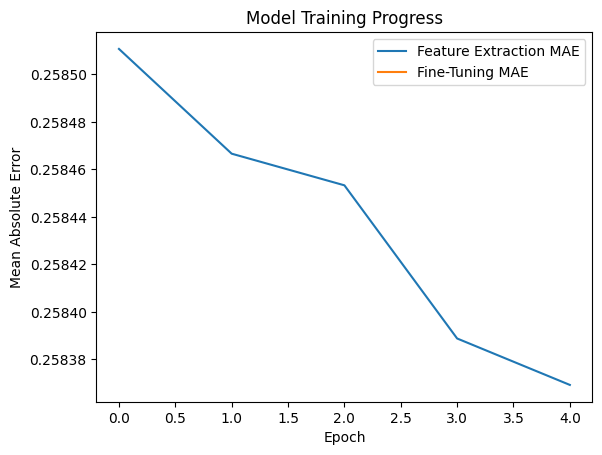

In [22]:
plt.plot(feature_history.history['mae'], label='Feature Extraction MAE')
plt.plot(fine_tune_history.history['mae'], label='Fine-Tuning MAE')
plt.title('Model Training Progress')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()
